Dataset from:
https://doi.org/10.1007/s11263-019-01215-y

Pose Pipeline:
* For each frame in a video:
    * bounding box with YoloV8 for each person
        * for each bounding box perform pose detection with mediapipe and encode coordinates
Model Classification:
* run coordinates through our Deep Learning Model & output estimated Body Language Emotion & strength

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import torch
import cv2
import matplotlib.pyplot as plt

from ultralytics import YOLO
from ultralytics.yolo.v8.detect.predict import DetectionPredictor

import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

In [2]:
train = pd.read_csv('annotations/train.csv')
test = pd.read_csv('annotations/val.csv')


emotion = ["Peace","Affection", "Esteem","Anticipation","Engagement","Confidence", "Happiness"
"Pleasure" ,"Excitement", "Surprise","Sympathy","Doubt/Confusion", "Disconnection","Fatigue", "Embarrassment",
"Yearning", "Disapproval", "Aversion", "Annoyance", "Anger", "Sensitivity", "Sadness", "Disquietment","Fear", 
"Pain", "Suffering"]

#4 metadata + 26 emotion levels(0.0-1.0 percent) + valence(1-10) + arousal(1-10) + dominance(1-10) + gender(0-1) + age(0-2)
# + ethnicity(0-6) + confidence (0.0-1.0)

train.head() #video path, person id, framerange start, framerange end, 26 columns for emotion classification, gender, age, ethnicity, confidence of current sample ground truth

,video path,person id,framerange start,framerange end,peace,affection,esteem,anticipation,engagement,confidence,...,fear,pain,suffering,valence,arousal,dominance,gender,age,ethnicity,confidence of current sample ground truth
0,003/IzvOYVMltkI.mp4/0114.mp4,3,96,124,7.584470e-01,2.456076e-01,7.624894e-01,1.000000e+00,1.950000e-16,1.240000e-144,...,0.000000e+00,0.000000e+00,1.920000e-168,7.399637,5.347943,5.037566,0,2,5,0.989108
1,003/IzvOYVMltkI.mp4/0114.mp4,4,65,124,3.199790e-02,1.820000e-135,3.190000e-32,1.000000e+00,1.780000e-96,5.619127e-01,...,3.970000e-254,7.980000e-129,5.700000e-70,8.196524,8.125158,5.751267,1,2,6,0.995089
2,003/y7ncweROe9U.mp4/0130.mp4,0,20,72,3.460000e-11,1.680000e-11,1.590000e-73,6.120000e-143,3.441052e-02,1.190000e-187,...,2.630000e-90,3.660000e-45,1.889652e-01,3.418884,7.433074,7.020448,0,2,6,0.996510
3,003/y7ncweROe9U.mp4/0130.mp4,1,0,50,1.317727e-01,6.020000e-81,4.019926e-02,1.436238e-01,7.467580e-01,1.182821e-01,...,0.000000e+00,3.940000e-59,3.214524e-01,3.668987,4.300627,6.929638,0,2,6,0.995974
4,003/IKdBLciu_-A.mp4/0015.mp4,0,0,158,3.350000e-31,0.000000e+00,2.455900e-02,1.470000e-59,1.262255e-01,4.050000e-49,...,9.340000e-118,0.000000e+00,1.260000e-132,4.439887,4.951530,5.892768,0,2,6,0.997584


In [19]:
def draw_boxes(image,coords, category):
    x1=int(coords[0])
    y1=int(coords[1])
    x2=int(coords[2])
    y2=int(coords[3])
    print(x1,y1,x2,y2)
    cv2.putText(image, category, (x1,y1), 0, 1, (255, 0, 0), 15, cv2.LINE_AA)
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,255), 5)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
# given array of coco poses, plot and save them if it matches personid
def plot_coords_for_person_id(frame, cocopose, personid):
    coords = []

    #is this the right person?
    if int(cocopose[1]) != personid:
        return False
    
    #loop over each pair of coordinates, visibility metric
    for i in range(2, cocopose.shape[0], 3):
        if cocopose[i+2] > 0: #is the coordinate visible?
            xp=int(cocopose[i])
            yp=int(cocopose[i+1])
            print(xp, yp)
            coords.append([xp, yp])
            cv2.circle(frame, (xp, yp), 5, (0, 255, 0),thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame, "Person:{}".format(int(cocopose[1])), (70, 96), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            
    return coords

#bounding box, array of x,y coordinate pair arrays
def isThisBoxAroundTheRightPerson(box, currentCoords):
    #box = [70, 475, 96, 359] # box(x1,y1,x2,y2), coords[(x,y,v),...]
    truebool = 0
    for i in range(2, 54, 3):
        #print(currentCoords[i],  currentCoords[i+1])
        #print( box[0], box[1],  box[2], box[3])
        if (currentCoords[i] >= box[0] and currentCoords[i] <= box[2]) and (currentCoords[i+1] >= box[1] and currentCoords[i+1] <= box[3]):
            #print(True)
            truebool +=1
    if truebool == 18 or truebool == 9: #full 18 x,y, v coords of body or full 9 of face & upper body
        #plt.imshow(cv2.cvtColor(frame[96:359, 70:475], cv2.COLOR_BGR2RGB)) #y1:y2, x1:x2 <-Reversed X and Y
        #print("Correct Person ID matched!")
        return True
    else:
        return False
#modified:
#https://github.com/nicknochnack/Body-Language-Decoder
def drawMediaPipeCoords(frame):
    # Initiate holistic model
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5, static_image_mode=False) as holistic:
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = holistic.process(image)

        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks

        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # 1. Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
        mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
        mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
        )

        # 2. Right hand
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
        mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
        )

        # 3. Left Hand
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
        mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
        )

        # 4. Pose Detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
        mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )
        
        pose=[]
        pose_row=[]
        face=[]
        face_row=[]
        
        # Extract Pose landmarks
        if results.pose_landmarks != None:
            pose = results.pose_landmarks.landmark
            pose_row = list(np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose]).flatten())
        
        # Export coordinates
        # Extract Face landmarks
        if results.face_landmarks != None:
            face = results.face_landmarks.landmark
            face_row = list(np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in face]).flatten())

        # Concate rows
        row = pose_row+face_row

        # (x,y,visibility) for each 501 coordinates to make 1503 33 pose landmarks, 468 face landmarks, and 21 hand landmarks per hand
        X = row
        return (image, X)


    
"""
#######################
#### MAIN PIPELINE ####
#######################
"""

    
persondetector = YOLO("yolov8s.pt")
    
currentVideoNum = 0
for path, personid in train[["video path", "person id"]].values[:1]:
    try:
        print(path, personid)
        os.mkdir("outputs/"+path.split("/")[1] + path.split("/")[2] + "_" + str(personid))
        cap = cv2.VideoCapture(os.path.join("videos", path.replace("/", "\\")))
        currentcocopose = np.load(os.path.join("joints", path.replace("/", "\\"))[:-4] + ".npy")

        ret, frame = cap.read()

        originalframe = frame

        zero = int(currentcocopose[0][0])

        framestogo = []
        exd = pd.DataFrame(data=currentcocopose)
        q = exd.loc[exd.iloc[:,1] ==personid,:]
        for index, row in q.iterrows():
            framestogo.append(int(row.iloc[0]) - zero)

        currentPoses = []
        #for each frame in current video:
        for f in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            if f in framestogo:    
                cap.set(cv2.CAP_PROP_FRAME_COUNT, f)
                ret, frame = cap.read()
                if ret == True:
                    #YOLO bounding boxes for each person
                    detections = persondetector.predict(frame, verbose=False)

                    boundingboxes = detections[0].boxes.xyxy

                    for i in range(boundingboxes.shape[0]): #for each detected box, make sure:
                        if detections[0].boxes.cls[i] == torch.tensor(0.0): # that this detection is a person only
                            #draw_boxes(frame, boundingboxes[i], "")
                            #print(boundingboxes[i], currentpose)

                            #find a match for the correct bounding box to the coco pose coordinates of the current personid
                            currentpose = exd.iloc[f, :].to_numpy()

                            if isThisBoxAroundTheRightPerson(boundingboxes[i], currentpose):
                                #use correct bounding box to crop the current frame
                                croppedframe = originalframe[int(boundingboxes[i][1].item()):int(boundingboxes[i][3].item()), int(boundingboxes[i][0].item()):int(boundingboxes[i][2].item())]

                                #cv2.imwrite("frame{}.png".format(str(f)), croppedframe)

                                mediapipecoords = drawMediaPipeCoords(croppedframe)
                                if mediapipecoords != None:
                                    #plt.imshow(cv2.cvtColor(mediapipecoords[0], cv2.COLOR_BGR2RGB)) #y1:y2, x1:x2 <-Reversed X and Y

                                    #get final pose coordinates from mediapipe pose detection for current frame
                                    currentPoses.append(mediapipecoords[1])

                                else:
                                    continue
                    #when done with current video, export all coordinates for that person in the full video as n x 2004 matrix
                    video = train.loc[train["video path"] == path]
                    video = video.loc[train["person id"] == personid]
                    y = video.to_numpy()[:, 4:-4]
                    np.save(path.split("/")[1] + path.split("/")[2] + "_" + str(personid) + "/outputs/" + "y.npy", y)

                    np.save(path.split("/")[1] + path.split("/")[2] + "_" + str(personid) + "/outputs/" + "X.npy", np.array(currentPoses, dtype=object))
                    print("video:"+str(round(currentVideoNum/train[["video path", "person id"]].values.shape[0] * 100, 2)))
                    currentVideoNum+=1
    except:
        print("Error Occured with training sample")
        continue

003/IzvOYVMltkI.mp4/0114.mp4 3
Error Occured with training sample


In [10]:
"outputs/"+path.split("/")[1] + path.split("/")[2] + "_" + str(personid)

'outputs/IzvOYVMltkI.mp40114.mp4_3'

# Development & Testing

In [169]:
video = train.loc[train["video path"] == "003/IzvOYVMltkI.mp4/0114.mp4"]
video = video.loc[train["person id"] == 3]
video.to_numpy()[:, 4:-4][0]

array([0.75844701, 0.245607598, 0.762489354, 1.0, 1.95e-16, 1.2400000000000001e-144, 1.0, 4.34e-90, 1.0, 0.019599238, 1.1099999999999999e-172, 0.274809104, 6.26e-60, 0.0, 6.969999999999999e-89, 0.038439217, 2.16e-06, 5.18e-114, 2.57e-17, 1.81e-66, 0.040922158, 4.68e-82, 2.4399999999999998e-45, 0.0, 0.0,
       1.9199999999999999e-168, 7.399636542, 5.347943304, 5.037566311], dtype=object)

In [94]:
train.iloc[:, 4:-4]

,peace,affection,esteem,anticipation,engagement,confidence,happiness,pleasure,excitement,surprise,...,anger,sensitivity,sadness,disquietment,fear,pain,suffering,valence,arousal,dominance
0,7.584470e-01,2.456076e-01,7.624894e-01,1.000000e+00,1.950000e-16,1.240000e-144,1.000000e+00,4.340000e-90,1.000000e+00,1.959924e-02,...,1.810000e-66,4.092216e-02,4.680000e-82,2.440000e-45,0.000000e+00,0.000000e+00,1.920000e-168,7.399637,5.347943,5.037566
1,3.199790e-02,1.820000e-135,3.190000e-32,1.000000e+00,1.780000e-96,5.619127e-01,1.000000e+00,1.000000e+00,1.000000e+00,7.346388e-02,...,5.530000e-154,0.000000e+00,1.400000e-263,3.050000e-22,3.970000e-254,7.980000e-129,5.700000e-70,8.196524,8.125158,5.751267
2,3.460000e-11,1.680000e-11,1.590000e-73,6.120000e-143,3.441052e-02,1.190000e-187,5.670000e-139,9.074395e-02,1.000000e+00,3.990000e-30,...,1.000000e+00,2.835150e-02,0.000000e+00,9.750000e-05,2.630000e-90,3.660000e-45,1.889652e-01,3.418884,7.433074,7.020448
3,1.317727e-01,6.020000e-81,4.019926e-02,1.436238e-01,7.467580e-01,1.182821e-01,0.000000e+00,7.540000e-83,2.442661e-02,0.000000e+00,...,1.630000e-30,2.351048e-02,1.990450e-01,8.660320e-01,0.000000e+00,3.940000e-59,3.214524e-01,3.668987,4.300627,6.929638
4,3.350000e-31,0.000000e+00,2.455900e-02,1.470000e-59,1.262255e-01,4.050000e-49,0.000000e+00,8.850000e-138,2.780000e-126,1.052751e-01,...,1.530000e-90,1.090000e-53,7.390000e-32,3.048064e-01,9.340000e-118,0.000000e+00,1.260000e-132,4.439887,4.951530,5.892768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9217,1.170000e-10,8.230000e-08,2.808229e-02,1.380000e-07,7.718366e-01,5.379535e-02,9.170000e-79,6.860000e-42,1.338923e-02,4.430000e-21,...,3.042590e-02,1.345508e-02,7.740000e-146,7.570000e-37,1.093680e-04,1.599538e-02,3.392346e-02,5.869617,4.677963,5.219032
9218,2.282926e-01,8.532084e-01,5.342110e-01,2.695066e-01,2.784077e-01,8.850892e-01,1.000000e+00,1.000000e+00,5.000000e-67,6.056055e-02,...,2.460000e-90,1.190000e-52,2.630000e-124,1.559880e-02,1.360000e-204,9.300000e-240,1.060000e-95,8.757378,6.193161,7.012679
9219,1.000000e+00,0.000000e+00,1.150000e-28,3.120000e-136,2.420000e-59,1.000000e+00,1.000000e+00,9.999994e-01,1.000000e+00,2.935119e-03,...,1.910000e-66,3.770000e-52,1.440000e-260,2.200000e-48,0.000000e+00,1.030000e-127,4.700000e-245,7.268292,6.952658,7.409891
9220,5.900000e-12,1.989153e-02,1.070000e-136,2.630000e-24,8.140000e-44,3.652874e-01,1.000000e+00,1.000000e+00,1.000000e+00,4.680000e-21,...,5.019979e-02,2.990000e-07,0.000000e+00,5.801961e-02,2.416565e-02,8.660000e-86,2.024247e-02,7.660593,5.775118,6.155090


In [114]:
train[["video path", "person id"]].values

array([['003/IzvOYVMltkI.mp4/0114.mp4', 3],
       ['003/IzvOYVMltkI.mp4/0114.mp4', 4],
       ['003/y7ncweROe9U.mp4/0130.mp4', 0],
       ...,
       ['003/xp67EC-Hvwk.mp4/0079.mp4', 1],
       ['003/IzvOYVMltkI.mp4/0114.mp4', 0],
       ['003/IzvOYVMltkI.mp4/0114.mp4', 2]], dtype=object)

In [4]:
6891/9222 #videos with 1 person

0.747234873129473

<AxesSubplot:>

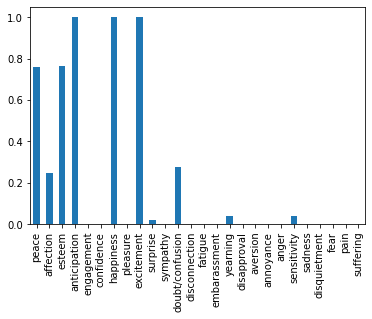

In [20]:
train.iloc[0, 4:30].plot.bar()

<AxesSubplot:>

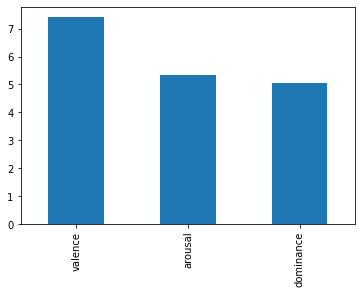

In [17]:
train.iloc[0, 30:-4].plot.bar() #scaled 1-10, scale this down to [0,1]

In [137]:
cap = cv2.VideoCapture(r'C:\Users\Alex Zavalny\Desktop\BOLD_public\videos\003\_7oWZq_s_Sk.mp4\0907.mp4')
ret, frame = cap.read()

persondetector = YOLO("yolov8s.pt")
res = persondetector.predict(frame)


0: 480x640 2 persons, 1 cup, 302.7ms
Speed: 4.0ms preprocess, 302.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


In [155]:
res[0].boxes

WARNING  'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[7.0726e+01, 9.6521e+01, 4.7570e+02, 3.5960e+02, 8.0794e-01, 0.0000e+00],
        [6.8748e+00, 1.6247e+01, 1.8588e+02, 3.5924e+02, 5.4619e-01, 0.0000e+00],
        [1.0663e+02, 2.8876e+02, 1.7422e+02, 3.5980e+02, 3.6200e-01, 4.1000e+01]])
cls: tensor([ 0.,  0., 41.])
conf: tensor([0.8079, 0.5462, 0.3620])
data: tensor([[7.0726e+01, 9.6521e+01, 4.7570e+02, 3.5960e+02, 8.0794e-01, 0.0000e+00],
        [6.8748e+00, 1.6247e+01, 1.8588e+02, 3.5924e+02, 5.4619e-01, 0.0000e+00],
        [1.0663e+02, 2.8876e+02, 1.7422e+02, 3.5980e+02, 3.6200e-01, 4.1000e+01]])
id: None
is_track: False
orig_shape: tensor([360, 480])
shape: torch.Size([3, 6])
xywh: tensor([[273.2152, 228.0605, 404.9776, 263.0800],
        [ 96.3782, 187.7450, 179.0068, 342.9960],
        [140.4231, 324.2797,  67.5942,  71.0446]])
xywhn: tensor([[0.5692, 0.6335, 0.8437, 0.7308],
        [0.2008, 0.5215, 0.3729, 0.9528],
        [0.2925, 0.9008, 0.1408,

70 96 475 359
6 16 185 359


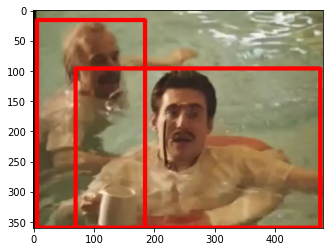

In [35]:
def draw_boxes(image,coords, category):
    x1=int(coords[0])
    y1=int(coords[1])
    x2=int(coords[2])
    y2=int(coords[3])
    print(x1,y1,x2,y2)
    cv2.putText(image, category, (x1,y1), 0, 1, (255, 0, 0), 15, cv2.LINE_AA)
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,255), 5)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
2 = res[0].boxes.xyxy
for i in range(bbox.shape[0]):
    if res[0].boxes.cls[i] == torch.tensor(0.0): #this detection is a person only
        draw_boxes(frame, bbox[i], "")

In [40]:
poses.shape #framenum from original source, personid, 54 coco coords

(378, 56)

In [ ]:
#ignore these
for i in range(poses.shape[0]): 
    print(poses[i,0])

In [59]:
poses[0, :]

array([ 1.7476e+05,           1,      129.78,      90.981,     0.80124,      104.39,      143.82,     0.28944,      52.688,      159.47,     0.40602,      52.696,      248.47,     0.52487,      137.56,       247.5,     0.30635,      145.37,      135.99,     0.14173,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,      107.32,      81.222,     0.81484,       135.6,
            74.342,      0.8722,      71.217,      99.793,     0.75565,           0,           0,           0])

245 186
245 255
148 262
338 246
430 271
229 167
265 169
201 182
291 186


[[245, 186],
 [245, 255],
 [148, 262],
 [338, 246],
 [430, 271],
 [229, 167],
 [265, 169],
 [201, 182],
 [291, 186]]

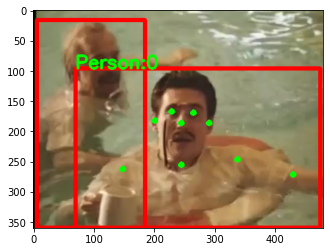

In [12]:
poses = np.load(r'C:\Users\Alex Zavalny\Desktop\BOLD_public\joints\003\_7oWZq_s_Sk.mp4\0907.npy')
person = 0

# given array of coco poses, plot and save them if it matches personid
def plot_coords_for_person_id(frame, cocopose, personid):
    coords = []

    #is this the right person?
    if int(cocopose[1]) != personid:
        return False
    
    #loop over each pair of coordinates, visibility metric
    for i in range(2, cocopose.shape[0], 3):
        if cocopose[i+2] > 0: #is the coordinate visible?
            xp=int(cocopose[i])
            yp=int(cocopose[i+1])
            print(xp, yp)
            coords.append([xp, yp])
            cv2.circle(frame, (xp, yp), 5, (0, 255, 0),thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame, "Person:{}".format(int(cocopose[1])), (70, 96), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            
    return coords
currentCoords = plot_coords_for_person_id(frame, poses[1, :], person)
currentCoords

True
True
True
True
True
True
True
True
True
Correct Person ID matched!


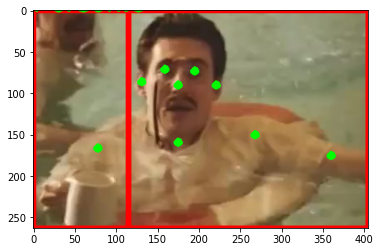

In [14]:
box = [70, 475, 96, 359] # (x1,y1,x2,y2) will be bbox[i] -> x1,x2, y1,y2
truebool = []

for c in currentCoords:
    if (c[0] >= box[0] and c[0] <= box[1]) and (c[1] >= box[2] and c[1] <= box[3]):
        print(True)
        truebool.append(True)
if len(truebool) == len(currentCoords):
    plt.imshow(cv2.cvtColor(frame[96:359, 70:475], cv2.COLOR_BGR2RGB)) #y1:y2, x1:x2 <-Reversed X and Y
    print("Correct Person ID matched!")

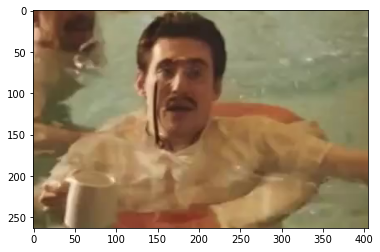

In [15]:
cap = cv2.VideoCapture(r'C:\Users\Alex Zavalny\Desktop\BOLD_public\videos\003\_7oWZq_s_Sk.mp4\0907.mp4')
ret, frame = cap.read()
plt.imshow(cv2.cvtColor(frame[96:359, 70:475], cv2.COLOR_BGR2RGB)) #y1:y2, x1:x2 <-Reversed X and Yoriginalframe

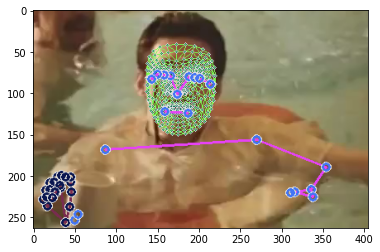

In [18]:
plt.imshow(cv2.cvtColor(drawMediaPipeCoords(frame[96:359, 70:475])[0], cv2.COLOR_BGR2RGB))

In [19]:
#for one frame matched with person id
coordsfrommediapipe = drawMediaPipeCoords(frame[96:359, 70:475])[1] #v = 0 means nonvisible, 1 = visible round v to int
coordsfrommediapipe

[0.4314240515232086,
 0.3846604824066162,
 -1.368140459060669,
 0.9998449087142944,
 0.46515151858329773,
 0.30770885944366455,
 -1.313633918762207,
 0.9998078942298889,
 0.48190659284591675,
 0.31019747257232666,
 -1.3137297630310059,
 0.9997515082359314,
 0.49856942892074585,
 0.3132544755935669,
 -1.3138426542282104,
 0.9997419714927673,
 0.41019850969314575,
 0.3010672330856323,
 -1.3187882900238037,
 0.9998449087142944,
 0.3907454013824463,
 0.2976188659667969,
 -1.3187543153762817,
 0.9998337030410767,
 0.3721799850463867,
 0.2963736057281494,
 -1.318909764289856,
 0.9998456239700317,
 0.5288715362548828,
 0.34007441997528076,
 -0.8300904035568237,
 0.9997958540916443,
 0.35448724031448364,
 0.3190340995788574,
 -0.8495033383369446,
 0.999850869178772,
 0.4634428322315216,
 0.4726989269256592,
 -1.175391674041748,
 0.9997895359992981,
 0.3941833972930908,
 0.4654984474182129,
 -1.1814634799957275,
 0.9998199343681335,
 0.6687489748001099,
 0.5944011211395264,
 -0.4404564499855041

In [94]:
len(coordsfrommediapipe)

2004

In [29]:
np.save("test.npy", np.array([coordsfrommediapipe]))

In [30]:
np.load("test.npy")

array([[    0.43142,     0.38466,     -1.3681, ...,      0.2777,    0.008174,           0]])

In [43]:
for path, personid in train[["video path", "person id"]].values[:2]:
    print(os.path.join("joints", path.replace("/", "\\"))[:-4] + ".npy")

joints\003\IzvOYVMltkI.mp4\0114.npy
joints\003\IzvOYVMltkI.mp4\0114.npy


In [60]:
poses[0]

array([ 1.7476e+05,           1,      129.78,      90.981,     0.80124,      104.39,      143.82,     0.28944,      52.688,      159.47,     0.40602,      52.696,      248.47,     0.52487,      137.56,       247.5,     0.30635,      145.37,      135.99,     0.14173,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,      107.32,      81.222,     0.81484,       135.6,
            74.342,      0.8722,      71.217,      99.793,     0.75565,           0,           0,           0])

In [12]:
ex = np.load(r"joints/003/IzvOYVMltkI.mp4/0114.npy")
ex

array([[      17292,           3,      270.25, ...,      286.83,      102.73,      0.7941],
       [      17292,           2,      433.18, ...,      452.69,      99.809,     0.84928],
       [      17292,           1,      192.18, ...,      201.95,       113.5,    0.094238],
       ...,
       [      17416,           4,      369.72, ...,      404.88,      134.01,     0.82593],
       [      17416,           3,      27.332, ...,      58.527,      121.32,     0.83245],
       [      17416,           2,      246.82, ...,      273.16,      113.51,     0.84667]])

In [27]:
ex[:,0]

array([      17292,       17292,       17292,       17292,       17293,       17293,       17293,       17293,       17294,       17294,       17294,       17294,       17295,       17295,       17295,       17295,       17296,       17296,       17296,       17296,       17297,       17297,       17297,       17297,
             17298,       17298,       17298,       17298,       17299,       17299,       17299,       17299,       17299,       17300,       17300,       17300,       17300,       17300,       17301,       17301,       17301,       17301,       17301,       17302,       17302,       17302,       17302,       17302,
             17303,       17303,       17303,       17303,       17303,       17304,       17304,       17304,       17304,       17304,       17305,       17305,       17305,       17305,       17305,       17306,       17306,       17306,       17306,       17306,       17307,       17307,       17307,       17307,
             17307,       17308,       1730

In [37]:
exd

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,17292.0,3.0,270.255,98.8062,0.926320,270.2290,134.032,0.886024,242.92900,130.127,...,0.898029,278.0470,96.8229,0.900985,261.4980,97.8023,0.226397,286.8320,102.7290,0.794097
1,17292.0,2.0,433.180,105.6240,0.898664,443.9090,133.027,0.856086,413.66900,134.031,...,0.849250,439.0080,99.7819,0.903724,0.0000,0.0000,0.000000,452.6860,99.8094,0.849283
2,17292.0,1.0,192.177,115.4440,0.896764,183.3910,144.801,0.888550,156.08600,142.846,...,0.921933,197.0630,110.5560,0.873394,169.7800,113.4680,0.882187,201.9530,113.5010,0.094238
3,17292.0,0.0,384.384,97.8595,0.891313,389.2500,122.290,0.873433,364.89300,121.327,...,0.869297,390.2530,93.9117,0.870376,376.5850,94.8773,0.136784,400.9730,97.7945,0.836579
4,17293.0,3.0,270.245,99.7929,0.909303,269.2890,135.958,0.885546,242.91500,132.075,...,0.893707,278.0350,97.8035,0.902152,261.4920,98.7854,0.210278,286.8440,104.6650,0.806214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,17415.0,3.0,35.147,120.3370,0.931166,43.9096,158.465,0.403813,0.00000,0.000,...,0.889652,43.9163,112.4990,0.884910,23.4047,112.5120,0.074420,65.3553,117.3880,0.790078
582,17415.0,2.0,251.695,117.4010,0.854048,273.1710,142.828,0.807052,240.01000,137.927,...,0.920456,259.5030,110.5580,0.945229,0.0000,0.0000,0.000000,278.0430,110.5290,0.887186
583,17416.0,4.0,369.717,135.0080,0.873851,393.1630,167.284,0.831349,359.03600,163.362,...,0.775924,378.5360,129.0970,0.876214,0.0000,0.0000,0.000000,404.8810,134.0070,0.825928
584,17416.0,3.0,27.332,121.3250,0.792440,36.1200,159.475,0.344491,2.89597,157.499,...,0.595485,37.0636,115.4280,0.848311,0.0000,0.0000,0.000000,58.5272,121.3210,0.832448


In [36]:
personid = 3.0

framestogo = []
exd = pd.DataFrame(data=ex)
q = exd.loc[exd.iloc[:,1] ==personid,:]
for index, row in q.iterrows():
    print(row.iloc[0])
    framestogo.append(int(row.iloc[0]))

17292.0
17293.0
17294.0
17295.0
17296.0
17297.0
17298.0
17299.0
17300.0
17301.0
17302.0
17303.0
17304.0
17305.0
17306.0
17307.0
17308.0
17309.0
17310.0
17311.0
17312.0
17313.0
17314.0
17315.0
17316.0
17317.0
17318.0
17319.0
17320.0
17321.0
17322.0
17323.0
17324.0
17325.0
17326.0
17327.0
17328.0
17329.0
17330.0
17331.0
17332.0
17333.0
17334.0
17335.0
17336.0
17337.0
17338.0
17339.0
17340.0
17341.0
17342.0
17343.0
17344.0
17345.0
17346.0
17347.0
17348.0
17349.0
17350.0
17351.0
17352.0
17353.0
17354.0
17355.0
17356.0
17357.0
17358.0
17359.0
17360.0
17361.0
17362.0
17363.0
17364.0
17365.0
17366.0
17367.0
17368.0
17369.0
17370.0
17371.0
17372.0
17373.0
17374.0
17375.0
17376.0
17377.0
17378.0
17379.0
17380.0
17381.0
17382.0
17383.0
17384.0
17385.0
17386.0
17387.0
17388.0
17389.0
17390.0
17391.0
17392.0
17393.0
17394.0
17395.0
17396.0
17397.0
17398.0
17399.0
17400.0
17401.0
17402.0
17403.0
17404.0
17405.0
17406.0
17407.0
17408.0
17409.0
17410.0
17411.0
17412.0
17413.0
17414.0
17415.0
17416.0


In [279]:
ex[0,:]

array([      17292,           3,      270.25,      98.806,     0.92632,      270.23,      134.03,     0.88602,      242.93,      130.13,     0.83208,      226.34,      173.13,     0.57069,      235.13,       220.1,     0.27616,      298.54,      137.94,     0.79425,       312.2,      178.03,     0.76142,      322.91,
            210.31,     0.57523,      248.79,      221.08,     0.69891,      248.78,      280.74,     0.74427,      251.71,      345.33,     0.70001,      283.93,      223.04,     0.68993,      280.97,      287.61,     0.73812,      276.08,      347.26,     0.69713,      268.31,      92.939,     0.89803,      278.05,
            96.823,     0.90099,       261.5,      97.802,      0.2264,      286.83,      102.73,      0.7941])

In [ ]:
list(ex[:, 1])

In [253]:
ex.shape

(586, 56)

In [261]:
framenum=0
personid=0
numids = np.unique(ex[:,1]).shape[0]

numids*framenum + (numids-personid)

5

In [116]:
train.loc[train["video path"] == "003/t0V4drbYDnc.mp4/0655.mp4"]

,video path,person id,framerange start,framerange end,peace,affection,esteem,anticipation,engagement,confidence,...,fear,pain,suffering,valence,arousal,dominance,gender,age,ethnicity,confidence of current sample ground truth
22,003/t0V4drbYDnc.mp4/0655.mp4,0,22,110,0.079623,5.610000e-24,1.670000e-33,0.902496,0.094982,0.016507,...,2.480000e-155,3.370000e-129,1.750000e-74,4.9183,6.037797,4.710526,0,2,6,0.985013


0.7902021408081055 0.5155807733535767 360 480
284 247
0.8351750373840332 0.45412373542785645 360 480
300 217
0.867129921913147 0.45713010430336 360 480
312 219
0.8944807648658752 0.4602326452732086 360 480
322 220
0.7363376617431641 0.44780829548835754 360 480
265 214
0.702457070350647 0.4471505880355835 360 480
252 214
0.6670705676078796 0.4469292163848877 360 480
240 214
0.9392909407615662 0.4936095178127289 360 480
338 236
0.6675768494606018 0.48182857036590576 360 480
240 231
0.8619614839553833 0.5922173261642456 360 480
310 284
0.748553991317749 0.5870645046234131 360 480
269 281
1.25217866897583 0.8552218079566956 360 480
450 410
0.4024949073791504 0.8516772985458374 360 480
144 408


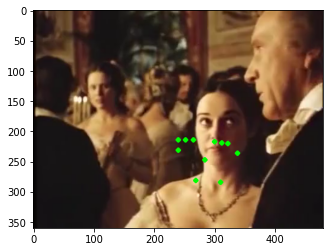

In [85]:
def plot_mediapipe_coords_for_person_id(frame, coords, personid):

    #loop over each pair of coordinates, visibility metric
    for i in range(0, coords.shape[0], 3):
        if coords[i+2] > 0.5: #is the coordinate visible?
            print(coords[i], coords[i+1], frame.shape[0], frame.shape[1])
            
            xp=int(coords[i]*frame.shape[0])
            yp=int(coords[i+1]*frame.shape[1])
            print(xp, yp)
            cv2.circle(frame, (xp, yp), 4, (0, 255, 0),thickness=-1, lineType=cv2.FILLED)
            #cv2.putText(frame, "Person:{}".format(int(cocopose[1])), (70, 96), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            

coords = np.load(r"C:\Users\Alex Zavalny\Desktop\BOLD_public\_7oWZq_s_Sk.mp40820.mp4_0\X.npy",allow_pickle=True)[0]
cap = cv2.VideoCapture(r"C:\Users\Alex Zavalny\Desktop\BOLD_public\videos\003\_7oWZq_s_Sk.mp4\0820.mp4")
ret, frame = cap.read()


plot_mediapipe_coords_for_person_id(frame, coords, 0)

108 134
122 193
72 200
102 297
167 190
186 270
153 249
93 328
151 323
99 123
120 123
88 131
147 134


[[108, 134],
 [122, 193],
 [72, 200],
 [102, 297],
 [167, 190],
 [186, 270],
 [153, 249],
 [93, 328],
 [151, 323],
 [99, 123],
 [120, 123],
 [88, 131],
 [147, 134]]

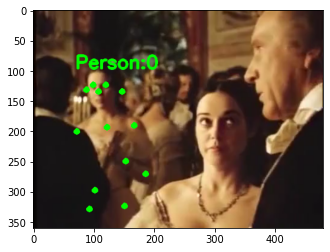

In [102]:
coords2 = np.load(r"C:\Users\Alex Zavalny\Desktop\BOLD_public\joints\003\_7oWZq_s_Sk.mp4\0820.npy",allow_pickle=True)
cap = cv2.VideoCapture(r"C:\Users\Alex Zavalny\Desktop\BOLD_public\videos\003\_7oWZq_s_Sk.mp4\0820.mp4")
ret, frame = cap.read()

plot_coords_for_person_id(frame, coords2[0], 0)

369 184
388 269
242 247
196 345
525 273
351 153
400 161
324 155
448 171


[[369, 184],
 [388, 269],
 [242, 247],
 [196, 345],
 [525, 273],
 [351, 153],
 [400, 161],
 [324, 155],
 [448, 171]]

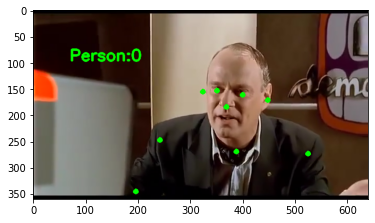

In [63]:
def plot_coords_for_person_id(frame, cocopose, personid):
    coords = []

    #is this the right person?
    if int(cocopose[1]) != personid:
        return False
    
    #loop over each pair of coordinates, visibility metric
    for i in range(2, cocopose.shape[0], 3):
        if cocopose[i+2] > 0: #is the coordinate visible?
            xp=int(cocopose[i])
            yp=int(cocopose[i+1])
            print(xp, yp)
            coords.append([xp, yp])
            cv2.circle(frame, (xp, yp), 5, (0, 255, 0),thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame, "Person:{}".format(int(cocopose[1])), (70, 96), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            
    return coords
currentCoords = plot_coords_for_person_id(frame, currentcocopose[1, :], 0)
currentCoords

182 62 564 354


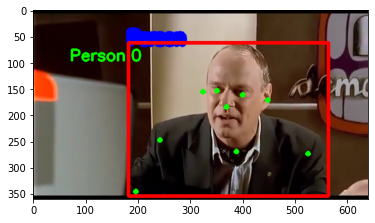

In [64]:
def draw_boxes(image,coords, category):
    x1=int(coords[0])
    y1=int(coords[1])
    x2=int(coords[2])
    y2=int(coords[3])
    print(x1,y1,x2,y2)
    cv2.putText(image, category, (x1,y1), 0, 1, (255, 0, 0), 15, cv2.LINE_AA)
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,255), 5)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    

        
draw_boxes(frame, boundingboxes[0], "Person")

* Frame by Frame detection:
    * For each frame run pose pipeline & predict on each pose
* Multi frame detection:
    * For x number of frames, run pose pipeline on each frame & concatenate or stack together coordinates
   

### Our model: 
$$f(\vec{X})\to \vec{y}, \\f([2004]) \to [26, 3]$$ 



In [ ]:
os.chdir("..")
os.getcwd()

In [ ]:
starts = list(train.iloc[:,2].to_numpy())
ends = list(train.iloc[:,3].to_numpy())

appeared = {} #only detect one person
clipnum = 0

coords = []
videos = list(train.iloc[:, 0].to_numpy())[:20]
for videopath in videos:
    #we haven't see this clip before:
    try:
        appeared[videopath]
        continue
    except KeyError:
        framenum = 0
        appeared[videopath] = 1
        START_FRAME = starts[clipnum]
        END_FRAME = ends[clipnum]
        
        current = videopath.split('/')
        root = os.getcwd()
        absolutepath = os.path.join(os.getcwd()[:-3], current[0], current[1], current[2])
        
        print(clipnum/len(videos), absolutepath)
        cap = cv2.VideoCapture(absolutepath)
        fps = cap.get(cv2.CAP_PROP_FPS)
        cap.set(0, int(round(START_FRAME*fps)))
        
        while cap.isOpened() and framenum <= END_FRAME:
            ret, frame = cap.read()
            if ret == True:
                det = drawClassInstance(frame)
                if det != None:
                    coords.append((videopath, list(det[1].to_numpy()[0])))
            else:
                break
            framenum+=1
        clipnum +=1

Training data: [2004] for each frame, hundreds of frames per individual sample of emotion


In [ ]:
coords

In [ ]:
import json

train = {"train":coords}

json.dump(train, open('train.json', 'w'))

In [ ]:
coords[0]

In [ ]:
#Prevent overfitting

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.97) and (logs.get('accuracy')>0.99) and (logs.get('val_loss')<0.2):
            print("\nReached 97% accuracy so cancelling training")
            self.model.stop_training = True

callbacks = myCallback()

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.models.Sequential([ 
    keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=X_train.shape[1:3]),
    keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train_enc, epochs=50, validation_data=(X_test, y_test_enc), callbacks=[callbacks])

In [ ]:
import json

json.dump(history.history, open('/content/model_history.json', 'w'))

In [ ]:
model.save("BodyLanguageClassifier.h5")